In [26]:
import pandas as pd
import requests
import os
from io import StringIO
from time import sleep

In [ ]:
def fetch_monthly_ohlcv(ticker):
    # Будем запрашивать данные за каждый год отдельно (ограничение ~1000 строк на запрос)
    all_data = pd.DataFrame()
    for year in range(1993, 2026):
        url = (
            f"https://iss.moex.com/iss/engines/stock/markets/shares/securities/"
            f"{ticker}/candles.csv?interval=24&from={year}-01-01&till={year}-12-31"
        )
        try:
            resp = requests.get(url)
            if resp.status_code != 200 or "Нет данных" in resp.text:
                continue
        except Exception as e:
            print(f"{ticker}: Error downloading year {year}")
            print(e)
            continue
            
        try:
            df_year = pd.read_csv(StringIO(resp.text), sep=';', skiprows=2)
        except Exception as e:
            print(f"{ticker}: Error reading year {year}")
            print(e)
            continue
        
        all_data = pd.concat([all_data, df_year], ignore_index=True)
        sleep(0.7)  # чтобы не попасть под лимиты

    if all_data.empty:
        return None
        
    all_data['begin'] = pd.to_datetime(all_data['begin'])
    all_data.set_index('begin', inplace=True)
    monthly = all_data.resample('ME').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'value': 'sum',
        'volume': 'sum'
    })
    monthly = monthly.dropna(how='all')  # убрать пустые месяцы
    
    return monthly

In [32]:
# Актуальный список тикеров из изображения
moex_index_tickers = [
    'AFKS', 'AFLT', 'ALRS', 'ASTR', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FEES', 'FLOT',
    'GAZP', 'GMKN', 'HEAD', 'HYDR', 'IRAO', 'LKOH', 'MAGN', 'MDMG', 'MOEX', 'MSNG',
    'MTSS', 'NLMK', 'NVTK', 'PHOR', 'PIKK', 'PLZL', 'POSI', 'RENI', 'ROSN', 'RTKM',
    'RUAL', 'SBER', 'SBERP', 'SNGS', 'SNGSP', 'SVCB', 'T', 'TATN', 'TATNP', 'TRNFP',
    'UGLD', 'UPRO', 'VKCO', 'VTBR', 'YDEX'
]

In [ ]:
for ticker in moex_index_tickers:
    print(f"Processing ticker: {ticker}")
    if ticker == 'YDEX':
        old = fetch_monthly_ohlcv('YNDX')  # до делистинга
        new = fetch_monthly_ohlcv('YDEX')  # после делистинга
        df = pd.concat([old, new])
        df = df[~df.index.duplicated(keep='last')]
        df = df.sort_index()
    elif ticker == 'HEAD':
        old = fetch_monthly_ohlcv('HHRU')  # до делистинга
        new = fetch_monthly_ohlcv('HEAD')  # после делистинга
        df = pd.concat([old, new])
        df = df[~df.index.duplicated(keep='last')]
        df = df.sort_index()
    else:
        df = fetch_monthly_ohlcv(ticker)

    if df is None:
        print(f"{ticker}: No data")
        continue
    display(df.head(5))
    df.to_csv(os.path.join("data", f'{ticker}.csv'))

# Bonds & liquidity ETF

In [36]:
bond_etf_tickers = ['AKMB', 'AKFB', 'SBRB', 'SBGB', 'OBLG', 'TBRU', 'SBMM']

In [37]:
for ticker in bond_etf_tickers:
    print(f"Processing ticker: {ticker}")
    
    df = fetch_monthly_ohlcv(ticker)

    if df is None:
        print(f"{ticker}: No data")
        continue
    display(df.head(5))
    df.to_csv(os.path.join("data", "bonds", f'{ticker}.csv'))

Processing ticker: AKMB


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2020-06-30,1.0030,1.0275,0.9972,1.0121,6.236956e+07,62055896
2020-07-31,1.0138,1.0392,1.0080,1.0190,3.211257e+07,31521153
2020-08-31,1.0201,1.0400,1.0130,1.0297,2.740642e+07,26719583
2020-09-30,1.0297,1.0525,1.0250,1.0372,7.448231e+07,72299501
2020-10-31,1.0372,1.0465,1.0351,1.0430,1.071169e+08,102971380


Processing ticker: AKFB


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2024-10-31,100.13,100.58,99.22,99.25,3.395295e+07,340827
2024-11-30,98.94,111.70,98.40,99.53,4.413704e+07,444286
2024-12-31,99.54,106.18,97.10,102.03,3.282421e+08,3263108
2025-01-31,102.04,105.00,101.48,104.41,4.517154e+08,4366406
2025-02-28,104.42,107.99,104.09,105.81,1.281589e+09,12190382


Processing ticker: SBRB


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2019-09-30,10.0200,10.4950,9.8875,10.1260,1.286988e+07,12752
2019-10-31,10.4979,10.7406,10.0724,10.2582,2.750846e+07,26953
2019-11-30,10.3199,10.4699,10.2205,10.3005,1.483843e+08,144163
2019-12-31,10.2924,10.6576,7.7790,10.6290,7.588302e+07,74699
2020-01-31,10.8415,10.8415,10.4506,10.5541,6.588442e+07,62497


Processing ticker: SBGB


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2019-01-31,10.032,10.066,9.988,10.064,2567867.0,2559
2019-02-28,10.264,10.492,9.898,10.084,13376836.8,13285
2019-03-31,10.284,10.430,9.912,10.160,9277237.6,9142
2019-04-30,10.138,10.456,10.018,10.298,14244415.6,13927
2019-05-31,10.426,10.984,10.192,10.480,213635338.4,205325


Processing ticker: OBLG


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2022-07-31,127.72,129.86,127.42,129.12,3.966631e+07,307862
2022-08-31,129.12,130.48,128.94,130.40,1.328757e+08,1022607
2022-09-30,130.04,131.90,123.00,127.74,2.416632e+08,1857977
2022-10-31,127.28,134.12,127.28,131.74,1.170803e+08,897063
2022-11-30,131.70,132.60,131.32,132.40,1.049552e+08,796145


Processing ticker: TBRU


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2021-07-31,5.014,5.027,4.977,5.026,1.918791e+08,38283949
2021-08-31,5.019,5.054,5.019,5.048,4.892911e+08,96970197
2021-09-30,5.047,5.060,5.022,5.045,3.597960e+08,71236614
2021-10-31,5.047,5.058,4.970,4.990,3.893419e+08,77449329
2021-11-30,4.993,5.001,4.902,4.930,3.095698e+08,62187307


Processing ticker: SBMM


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2021-10-31,10.003,12.000,10.002,10.053,5.032426e+07,5020496
2021-11-30,10.053,11.000,10.023,10.111,4.569291e+07,4536154
2021-12-31,10.073,10.450,10.073,10.174,2.961372e+08,29137893
2022-01-31,10.165,10.444,10.001,10.244,1.737008e+08,17007525
2022-02-28,10.438,11.300,9.311,10.260,4.690516e+08,45656723


# MOEX Index ETF

In [39]:
moex_index_etf_tickers  = ['AKME', 'SBMX']

In [40]:
for ticker in moex_index_etf_tickers:
    print(f"Processing ticker: {ticker}")
    
    df = fetch_monthly_ohlcv(ticker)

    if df is None:
        print(f"{ticker}: No data")
        continue
    display(df.head(5))
    df.to_csv(os.path.join("data", "moex_index", f'{ticker}.csv'))

Processing ticker: AKME


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2020-12-31,100.69,102.88,98.95,102.79,27835951.98,276840
2021-01-31,103.90,110.89,102.25,102.64,30185272.68,280867
2021-02-28,102.81,109.72,100.96,105.54,15226766.21,141341
2021-03-31,105.54,116.28,104.05,113.98,20585007.69,183388
2021-04-30,114.55,118.58,110.00,114.89,18653571.32,163052


Processing ticker: SBMX


C:\Users\pluso\AppData\Local\Temp\ipykernel_24760\1848860036.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df_year], ignore_index=True)


,open,high,low,close,value,volume
begin,,,,,,
2018-09-30,10.176,10.828,10.118,10.616,7638352.6,7366
2018-10-31,10.754,11.460,9.860,10.202,35131900.8,33887
2018-11-30,10.104,10.902,9.920,10.346,85446589.8,83163
2018-12-31,10.552,10.788,9.800,10.328,178303888.8,173014
2019-01-31,10.332,11.078,10.240,11.004,189645319.4,177565


In [ ]:
ticker = "MCFTRR"  # MOEX Russia Total Return Net

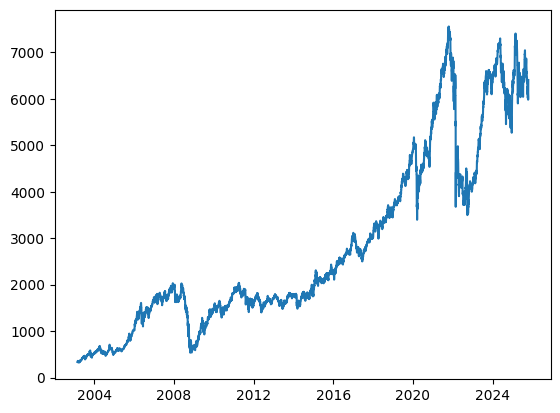

In [36]:
plt.plot(df_calendar["TRADEDATE"], df_calendar["CLOSE"])

In [39]:
df_calendar.columns = ['date', 'close', 'volume']
df_calendar.to_csv(os.path.join("..", "data", "indices", "MCFTRR.csv"), index=False)

Общая капа рынка акций РФ - 51300 млрд руб

MOEX учитывает капу неочевидно (free-float * какойто коэфф ограничивающий вес)